# Reservoir Output Prediction using data IMPUTATION

**Feature Description**:
- Priority
- sw
- Volume_reservoir
- Output


In [116]:
# Import Standard Libraries
import os
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import seaborn as sns

import mlflow

from pathlib import Path
from colorama import Style, Fore

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, LearningCurveDisplay, \
                                    learning_curve, ShuffleSplit, GridSearchCV, \
                                    KFold

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from scipy import stats

from xgboost import XGBRegressor

In [117]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [118]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

# Read Data

In [119]:
# Switch flag for Kaggle Cloud
kaggle = True

# Switch flag for including original dataset
include_original_data = True

In [120]:
# Read training data
if kaggle:
    
    # Read data from Kaggle FS
    data = pd.read_csv('data_training_2.csv', index_col=0)
    original_data = pd.read_csv('data_evaluate_2.csv', index_col=0)
    
else:
    
    # Define local data file paths
    data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E15' / 'heat_flux_feature_imputation_data.csv'
    original_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E15' / 'heat_flux_feature_imputation_original.csv'
   
    data = pd.read_csv(data_file_path, index_col=0)
    original_data = pd.read_csv(original_data_file_path, index_col=0)

In [121]:
data.head()

,Porositas,sw,Volume_Reservoir,Outcome
id,,,,
1,12.335009,42.065724,13036.51848,4788.160337
2,15.060259,51.069965,13034.12879,7096.091690
3,15.060259,51.069965,13036.12879,NaN
4,15.060259,51.069965,13017.32729,7086.944551
5,15.060504,25.063251,13029.61773,3481.350899


In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 700 entries, 1 to 700
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Porositas         700 non-null    float64
 1   sw                700 non-null    float64
 2   Volume_Reservoir  700 non-null    float64
 3   Outcome           686 non-null    float64
dtypes: float64(4)
memory usage: 27.3 KB


Since there are some null values in the `x_e_out [-]`, the data would be splitted as follow:
- Train Data: entries with `x_e_out [-]` non-null
- Test Data: entries with `x_e_out [-]` null

## Define Train and Test Data

In [123]:
# Define train_data
train_data = data[data['Outcome'].notnull()]

In [124]:
# Define test_data
test_data = data[data['Outcome'].isnull()]

# Exploratory Data Analysis (EDA)

In [112]:
# Define dictionary of data to plot
data_to_plot = {'Train': train_data, 
                'Test': test_data, 
                'Original': original_data}

## Shapes Information

In [113]:
# Print shapes information
print(f'{blue}Data Shapes:'
      f'{blue}\n- Train Data     -> {red}{train_data.shape}'
      f'{blue}\n- Original Data  -> {red}{original_data.shape}'
      f'{blue}\n- Test Data      -> {red}{test_data.shape}\n')

Data Shapes:
- Train Data     -> (686, 4)
- Original Data  -> (300, 4)
- Test Data      -> (14, 4)



## Null Values Information

In [114]:
# Print null values information
print(f'{blue}Data Columns with Null Values:'
      f'{blue}\n- Train Data     -> {red}{train_data.isnull().any().sum()}'
      f'{blue}\n- Original Data  -> {red}{original_data.isnull().any().sum()}'
      f'{blue}\n- Test Data      -> {red}{test_data.isnull().any().sum()}\n')

Data Columns with Null Values:
- Train Data     -> 0
- Original Data  -> 1
- Test Data      -> 1



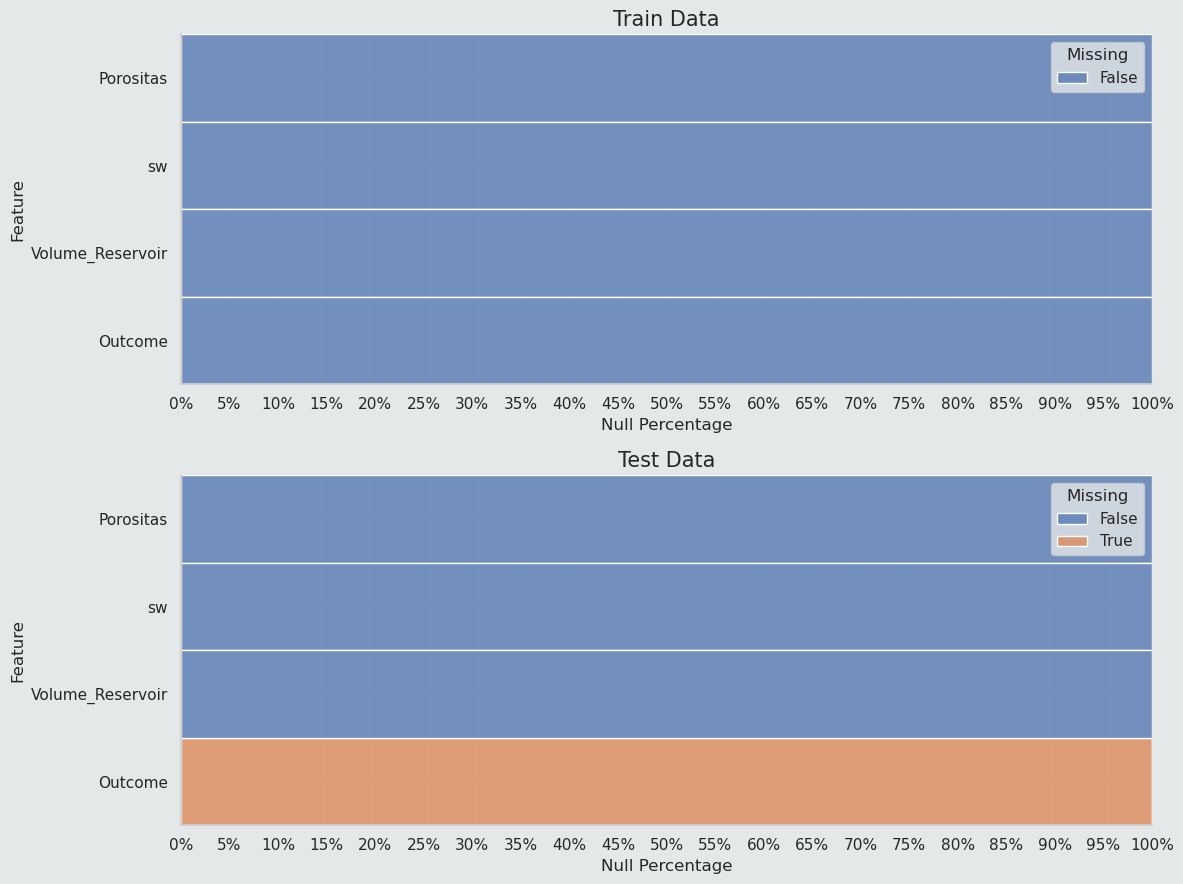

In [125]:
# Define data to display
data_to_display = {
    'Train Data': train_data,
    'Test Data': test_data
}

# Create figure
figure = plt.figure(tight_layout=True, figsize=(12, 9))

# Define figure's subplots
grid_spec = GridSpec(len(data_to_display), 1)

# Fetch data to plot
for row, (name, dataframe) in enumerate(data_to_display.items()):
    
    # Create subplot
    ax = figure.add_subplot(grid_spec[row, 0])
    
    sns.histplot(data=dataframe.isna().melt(var_name='Feature', value_name='Missing'), 
                 y='Feature', 
                 hue='Missing', 
                 multiple='fill',
                 ax=ax)
    
    # Refactor x label as missing percentage
    ax.xaxis.set_major_locator(ticker.LinearLocator(21))
    ax.xaxis.set_major_formatter('{:.0%}'.format)
    
    # Set title and label
    ax.set_title(name, fontsize=15)
    ax.set_xlabel('Null Percentage')

There is quite a huge amount of null values in most of the columns. Around 15% in all the features. Need to come up with a good imputation strategy.

## Feature Distribution

### Numerical Feature Distribution

In [97]:
# Define raw numerical features
raw_numerical_features = [
                          'Porositas', 
                          'sw', 
                          'Volume_Reservoir', 
                          'Outcome', 
                          ]

KeyError: 'index'

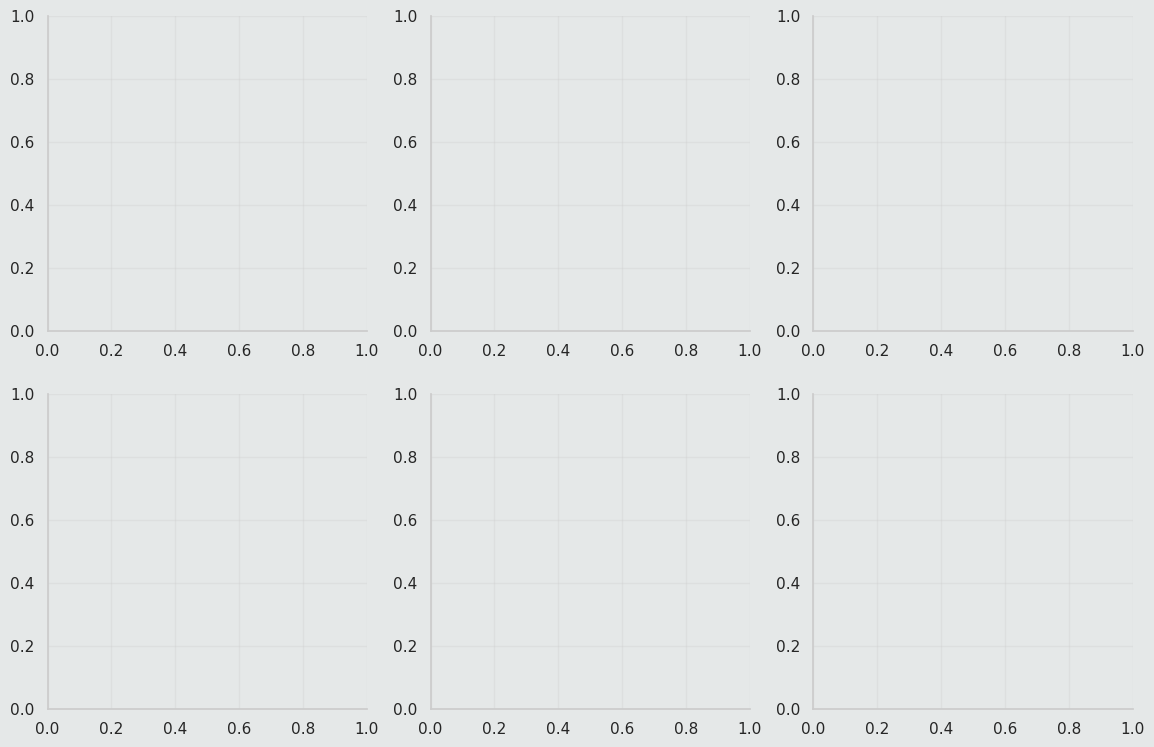

In [96]:
# Plot the KDE of each feature
figure, ax = plt.subplots(2, 3, figsize=(14, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features):
    
    # Plot data
    sns.kdeplot(data=train_data[column_name],
                label='Train',
                ax=ax[index])
    
    sns.kdeplot(data=test_data[column_name],
                label='Test',
                ax=ax[index])
    
    sns.kdeplot(data=original_data[column_name],
                label='Original',
                ax=ax[index])
    
    # Set subplot title
    ax[index].set_title(column_name, fontsize=14)
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

# Set figure Title
figure.suptitle('Numerical Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- `D_h [mm]` and `chf_exp [MW/m2` are strongly right-skewed
- `length [mm]` follows a Binomial distribution
- Since data have different scales, it is required to perform a Data Standardization

### Categorical Feature Distribution

#### Author Distribution

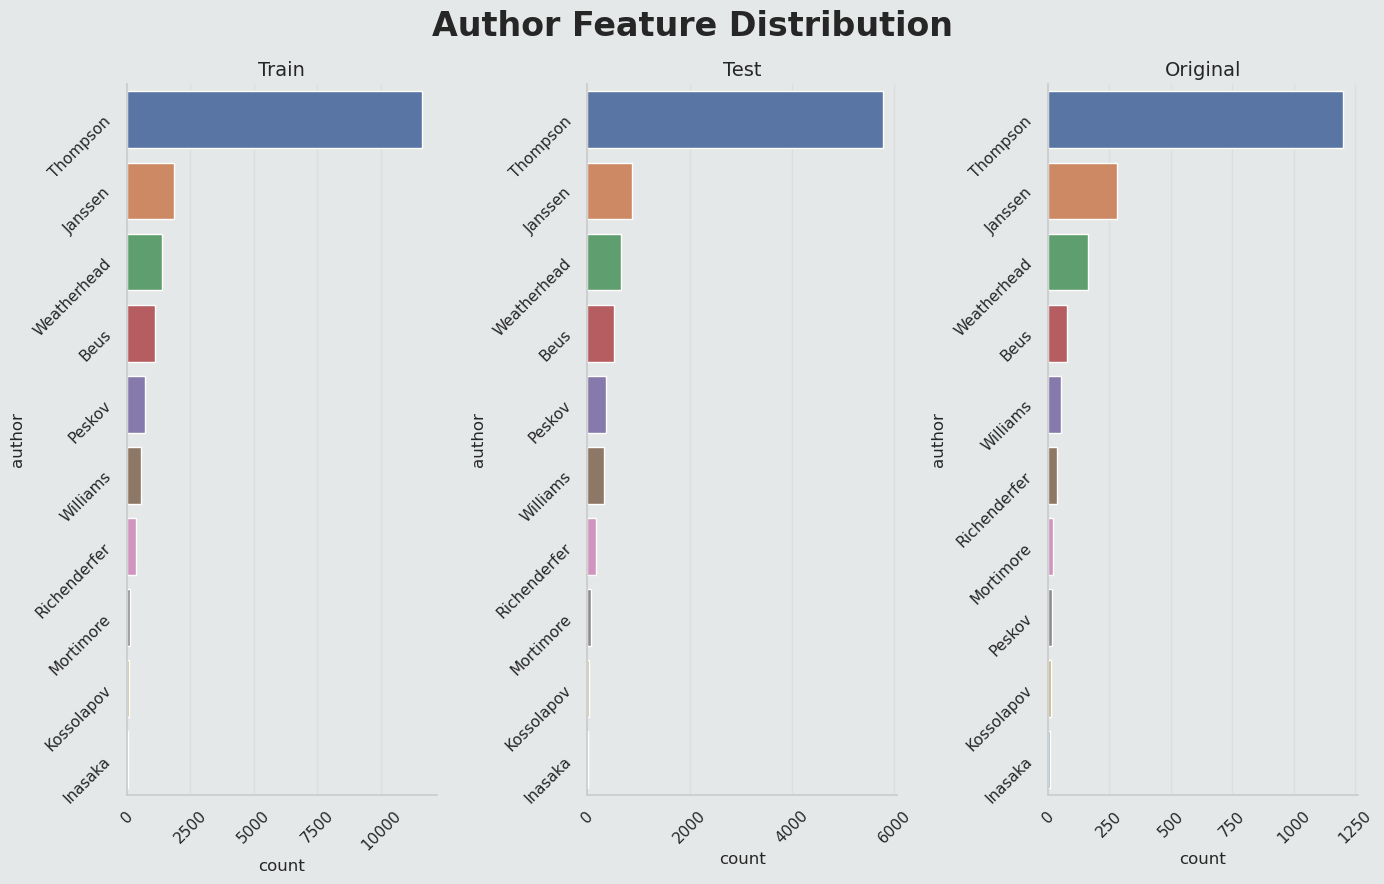

In [39]:
# Plot the countplot for the 'Author' feature
figure, ax = plt.subplots(1, 3, figsize=(14, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Plot data
    sns.countplot(data=data_to_plot[dataset_name],
                  y='author',
                  label=dataset_name,
                  order=data_to_plot[dataset_name]['author'].value_counts().index,
                  ax=ax[index])

    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Set subplot title
    ax[index].set_title(f'{dataset_name}', 
                        fontsize=14)

# Set figure Title
figure.suptitle('Author Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

There's a huge imbalanced distribution in such a feature.

#### Geometry Distribution

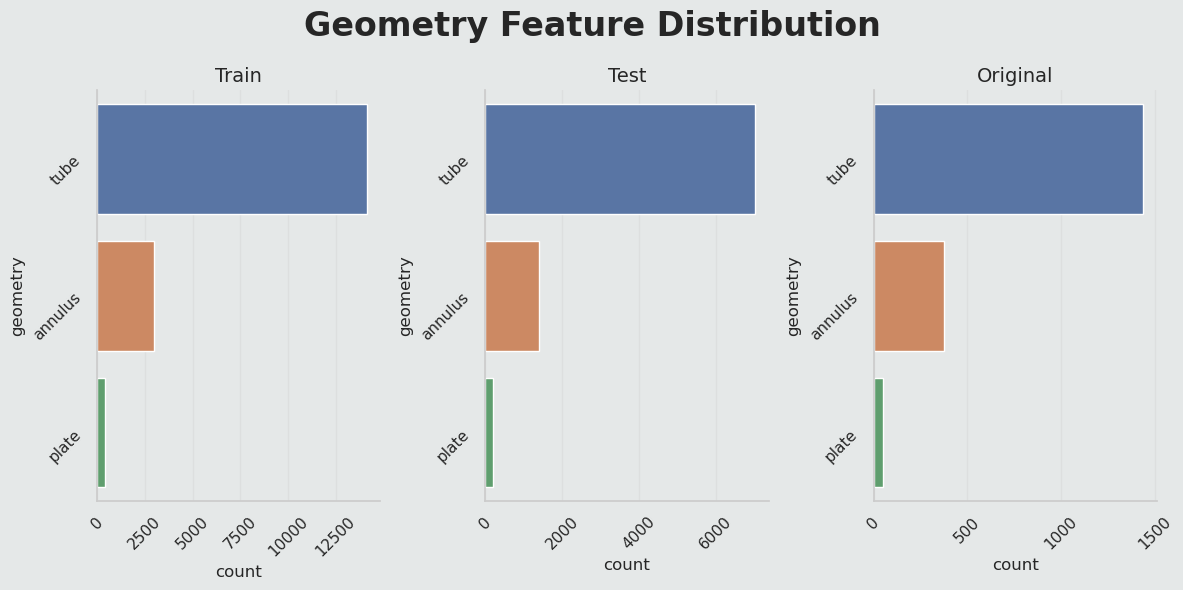

In [40]:
# Plot the countplot for the 'Geometry' feature
figure, ax = plt.subplots(1, 3, figsize=(12, 6))
ax = ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Plot data
    sns.countplot(data=data_to_plot[dataset_name],
                  y='geometry',
                  label=dataset_name,
                  order=data_to_plot[dataset_name]['geometry'].value_counts().index,
                  ax=ax[index])

    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Set subplot title
    ax[index].set_title(f'{dataset_name}', 
                        fontsize=14)

# Set figure Title
figure.suptitle('Geometry Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

### Feature Distribution per Author

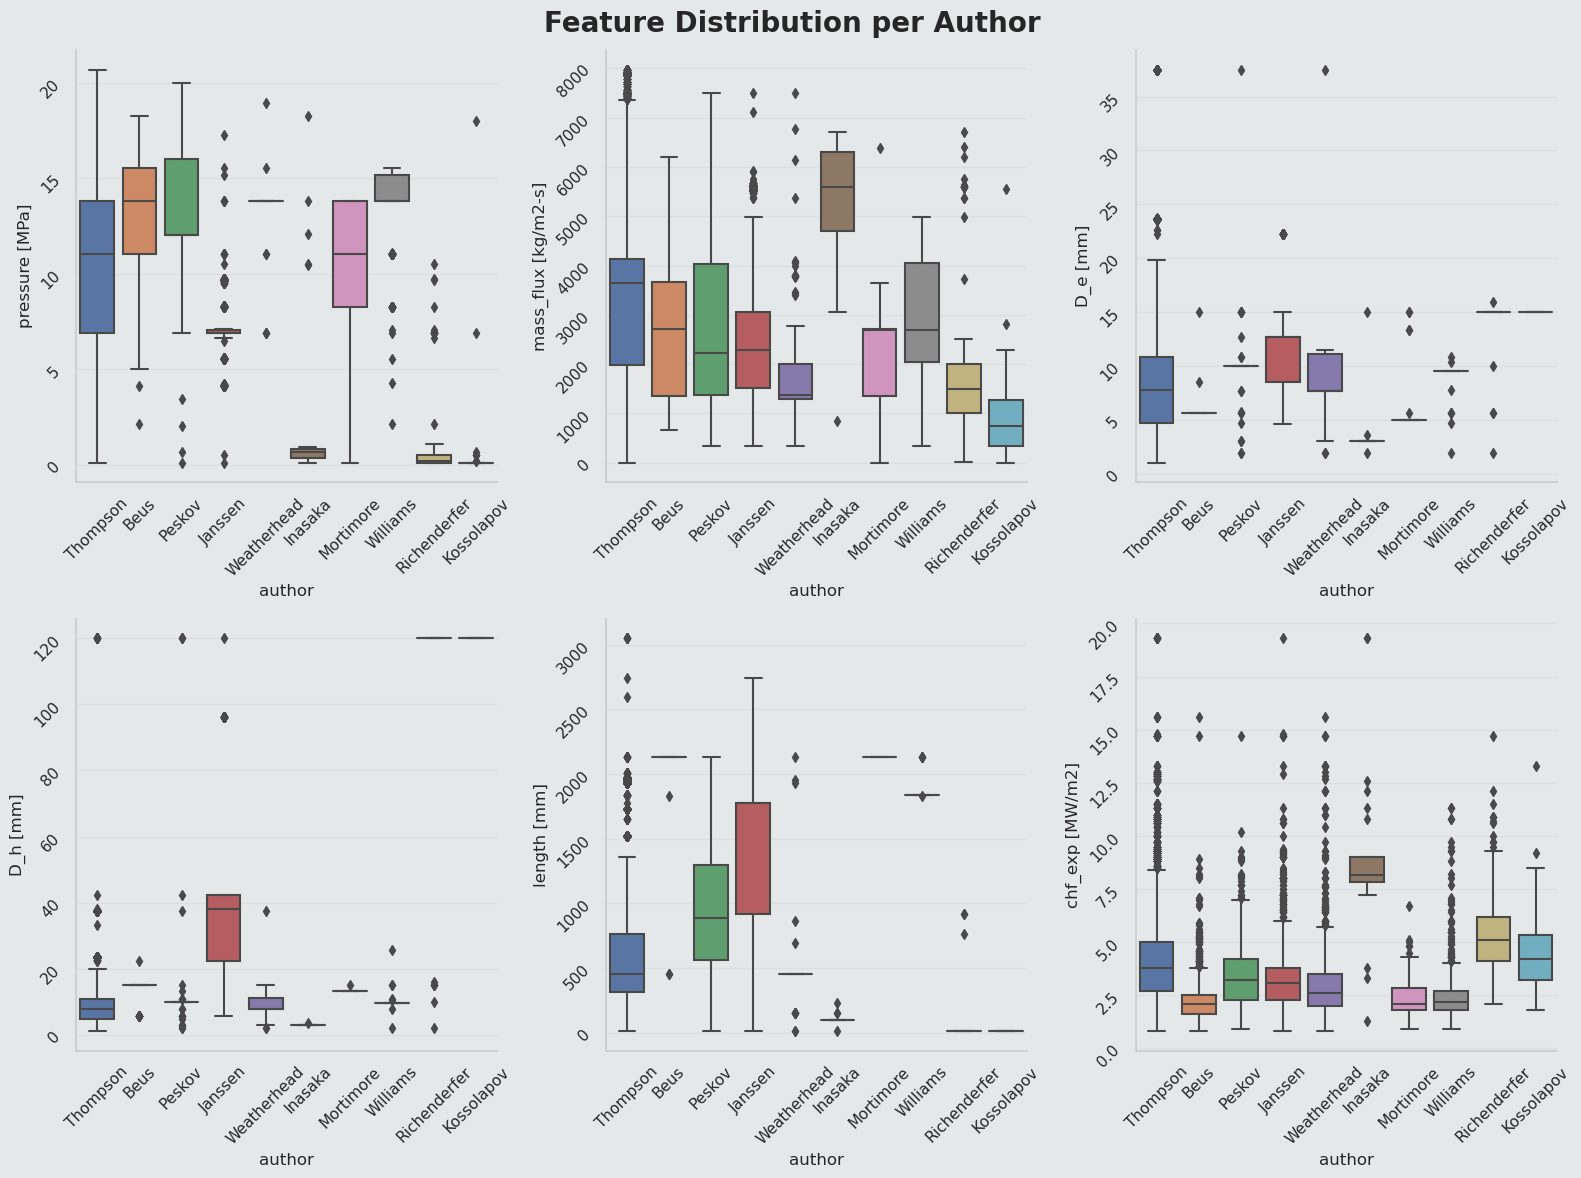

In [41]:
# Define figure and axes
figure, ax = plt.subplots(2, 3, figsize=(16, 12))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(train_data[raw_numerical_features]):
    
    # Plot data
    sns.boxplot(data=train_data,
                x='author',
                y=column_name,
                ax=ax[index])
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)

# Set figure Title
figure.suptitle('Feature Distribution per Author',
                fontweight='bold',
                fontsize=20)

plt.tight_layout()

There is no correlation between th `author` and the other features. Not include it in the feature list.

### Feature Distribution per Geometry

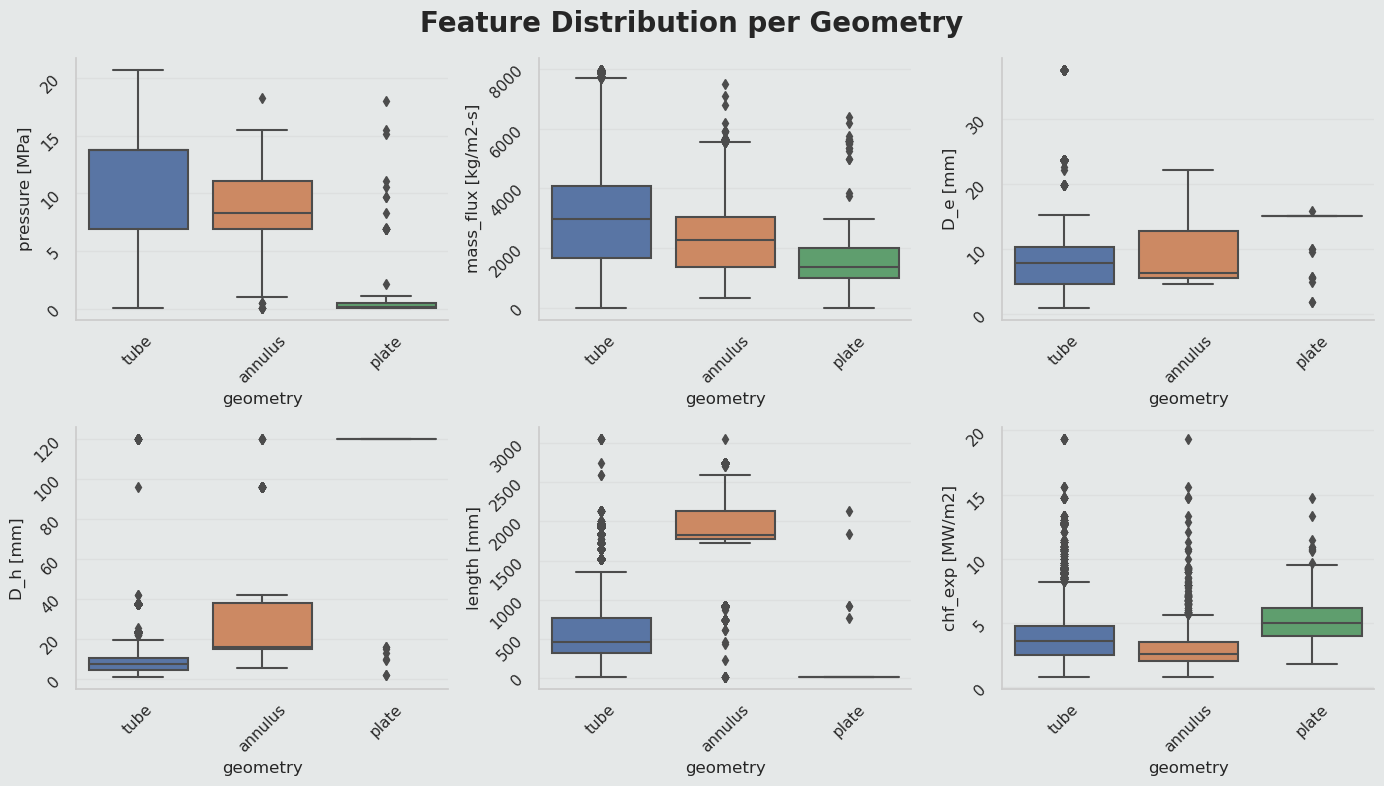

In [42]:
# Define figure and axes
figure, ax = plt.subplots(2, 3, figsize=(14, 8))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(train_data[raw_numerical_features]):
    
    # Plot data
    sns.boxplot(data=train_data,
                x='geometry',
                y=column_name,
                ax=ax[index])
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)

# Set figure Title
figure.suptitle('Feature Distribution per Geometry',
                fontweight='bold',
                fontsize=20)

plt.tight_layout()

Features are very different with respect to the geometry. It's important to include it as a feature

## Label Distribution

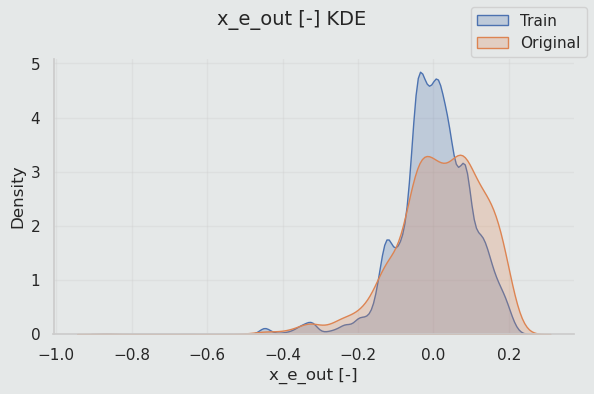

In [43]:
# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot the KDE of label
sns.kdeplot(data=train_data['x_e_out [-]'], 
            fill=True,
            label='Train')

sns.kdeplot(data=original_data['x_e_out [-]'], 
            fill=True,
            label='Original')

# Set figure title
figure.suptitle('x_e_out [-] KDE', fontsize=14)

figure.legend()

plt.tight_layout()

They have the same distribution between Train and Original dataset.

## Pearson Correlation

In [44]:
# Define raw numerical features
correlation_raw_numerical_features = ['pressure [MPa]',
                                      'mass_flux [kg/m2-s]',
                                      'D_e [mm]', 
                                      'D_h [mm]', 
                                      'length [mm]', 
                                      'chf_exp [MW/m2]', 
                                      'x_e_out [-]']

findfont: Font family ['Andale Mono'] not found. Falling back to DejaVu Sans.


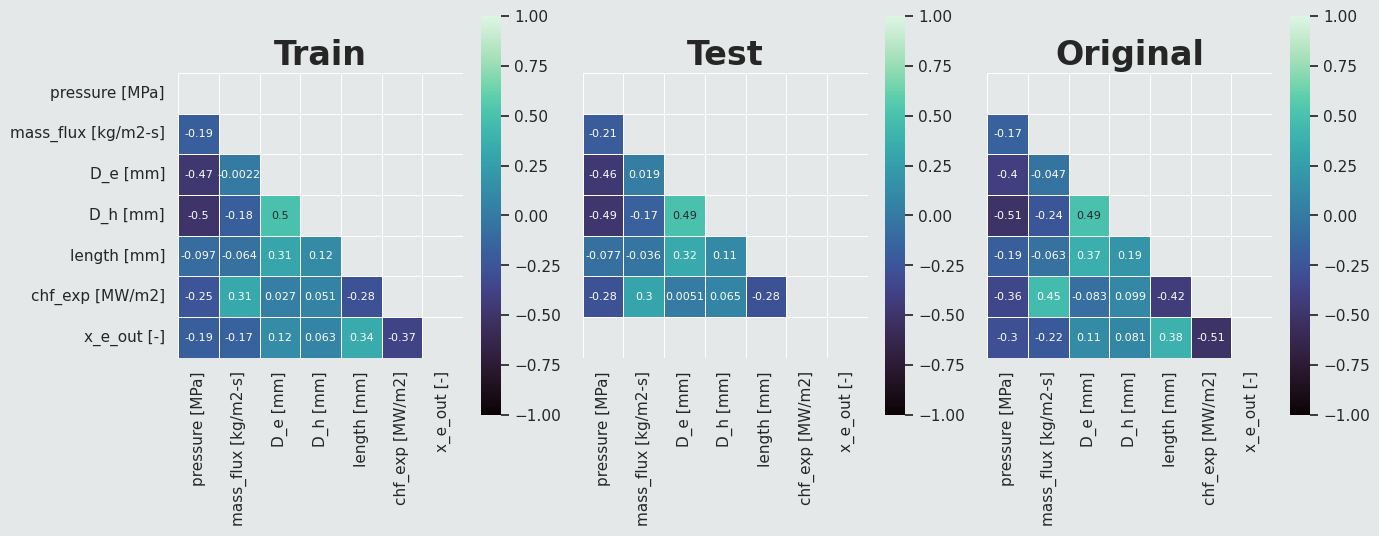

In [45]:
# Define figure and axis
figure, ax = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Compute the correlation matrix
    correlation_matrix = data_to_plot[dataset_name][correlation_raw_numerical_features].corr()
    
    # Generate a mask for the upper triangle
    correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot the correlation matrix
    sns.heatmap(correlation_matrix, 
                mask=correlation_mask, 
                cmap='mako',
                vmax=1.0, 
                vmin=-1.0, 
                center=0, 
                square=True, 
                linewidths=.5, 
                annot=True,
                annot_kws={'fontsize': 8},
                cbar_kws={"shrink":.8, 'orientation':'vertical'}, 
                ax=ax[index])

    # Set title
    ax[index].set_title(f'{dataset_name}',
                        fontweight='bold')


plt.tight_layout()

- Negative linear correlation between `D_e [mm]` and `pressure [MPa]`
- Negative linear correlation between `D_h [mm]` and `pressure [MPa]`
- Positive linear correlation between `D_h [mm]` and `D_e [mm]`

## Spearman Correlation

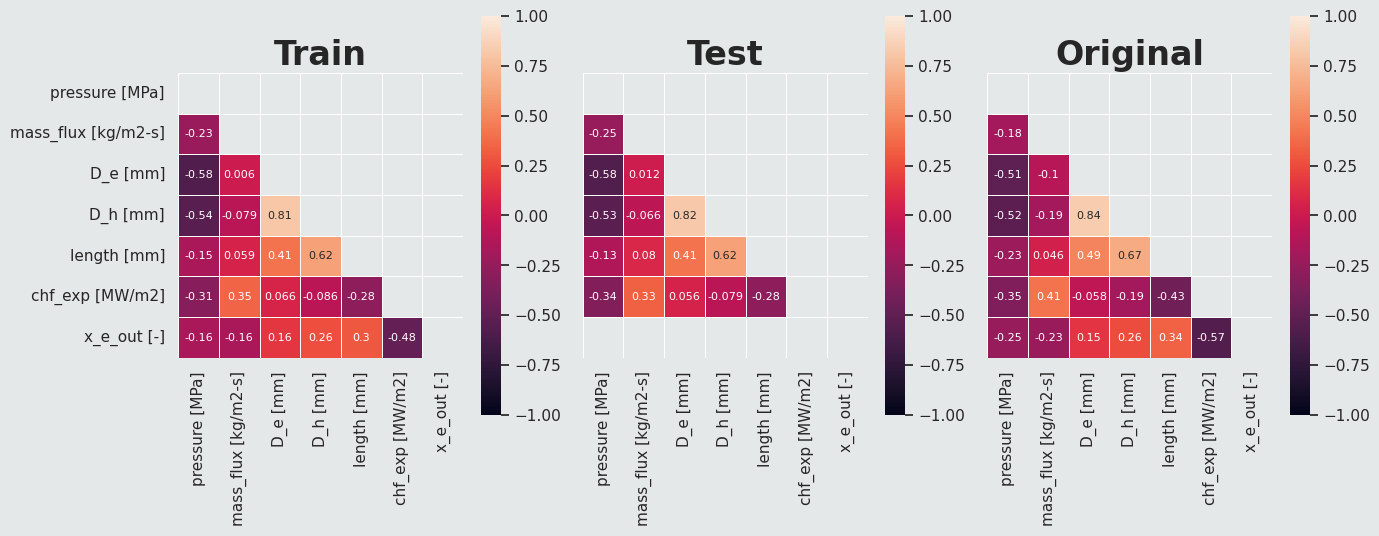

In [46]:
# Define figure and axis
figure, ax = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Compute the correlation matrix
    correlation_matrix = data_to_plot[dataset_name][correlation_raw_numerical_features].corr(method='spearman')
    
    # Generate a mask for the upper triangle
    correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot the correlation matrix
    sns.heatmap(correlation_matrix, 
                mask=correlation_mask, 
                cmap='rocket',
                vmax=1.0, 
                vmin=-1.0, 
                center=0, 
                square=True, 
                linewidths=.5, 
                annot=True,
                annot_kws={'fontsize': 8},
                cbar_kws={"shrink":.8, 'orientation':'vertical'}, 
                ax=ax[index])

    # Set title
    ax[index].set_title(f'{dataset_name}',
                        fontweight='bold')


plt.tight_layout()

- Positive non-linear correlation between `length [mm]` and `D_h [mm]`

## Conclusions 

- Perform column names data cleaning
- Impute null values
- Standardise numerical features since they have different ranges  
- Normalize the numerical features since their distributions are too different 
- One-hot Encoder for `geometry`
- Do not include `author`
- Negative linear correlation between `D_e` and `pressure` > Create `D_e over pressure`
- Negative linear correlation between `D_h` and `pressure` > Create `D_h over pressure`
- Positive linear correlation between `D_h` and `D_e` > Create `D_h per D_e`
- Positive non-linear correlation between `length` and `D_h` > Create `length per D_h`

# Data Preparation

## Data Cleaning

In [47]:
# Define pattern to pass to the regex 
pattern = r'\s\[.*?\]'

# Rename columns
train_data_cleaned = train_data.rename(columns=lambda x: re.sub(pattern, '', x))
test_data_cleaned = test_data.rename(columns=lambda x: re.sub(pattern, '', x))
original_data_cleaned = original_data.rename(columns=lambda x: re.sub(pattern, '', x))

## Feature Engineering

In [48]:
class ComputeNumericalEngineeredFeatures(BaseEstimator, TransformerMixin):
    """
    Create a pre-defined set of engineered feature to the input DataFrame
    """
    
    def fit( self, X, y = None ):
        """
        This method is not required for this transformer
        """
        return self
    
    def transform(self, X):
    
        # Create a feature `D_e over pressure`
        X['D_e over pressure'] = X['D_e'] / X['pressure']

        # Create a feature 'D_h over pressure'
        X['D_h over pressure'] = X['D_h'] / X['pressure']

        # Create a feature 'D_h per D_e'
        X['D_h per D_e'] = X['D_h'] * X['D_e']

        # Create a feature 'length per D_h'
        X['length per D_h'] = X['length'] * X['D_h']
        
        # Save column names
        self.feature_names = X.columns

        return X
    
    def get_feature_names_out(self, feature_names):
        """
        Retrieve the feature names
        """
        return [f'{col}' for col in self.feature_names]

## Data Pipeline

In [49]:
# Dictionary of data transformations to include
data_trasformations = {
    'numerical': {
        'feature_engineering': True,
        'imputation': True,
        'standardization': True,
        'normalization': True
    },
    'categorical': {
        'imputation': True,
        'one_hot_encoding': True,
    }
}

### Numerical Data Pipeline

In [50]:
class Log1pTransformer(BaseEstimator, TransformerMixin):
    """
    Implements a Numpy.log1p transformation for Scikit-Learn Pipeline
    """
    
    def fit(self, X, y=None):
        """
        This method is not required for this transformer
        """
        return self
    
    def transform(self, X):
        """
        Transform the data X with a Numpy.log1p transformation
        """
        # Apply np.log1p to the input array
        return np.log1p(X, where=True)
    
    def get_feature_names_out(self, feature_names):
        """
        Retrieve the feature names
        """
        return [f'{col}' for col in feature_names]

In [51]:
# Define numerical features
numerical_features = [
    'pressure', 
    'mass_flux', 
    'D_e', 
    'D_h', 
    'length', 
    'chf_exp'
]

In [52]:
# Define the numerical data pipeline steps based on data_trasformations['numerical']
numerical_data_pipeline_steps = []

if data_trasformations['numerical']['feature_engineering']:
    numerical_data_pipeline_steps.append(('feature_engineering', ComputeNumericalEngineeredFeatures()))
if data_trasformations['numerical']['imputation']:
    numerical_data_pipeline_steps.append(('imputation', SimpleImputer(strategy='median', copy=False)))
if data_trasformations['numerical']['standardization']:
    numerical_data_pipeline_steps.append(('standardization', MinMaxScaler()))
if data_trasformations['numerical']['normalization']:
    numerical_data_pipeline_steps.append(('normalization', Log1pTransformer()))

### Categorical Data Pipeline

In [53]:
# Define categorical features
categorical_features = [
    'geometry'
]

In [54]:
# Define the categorical data pipeline steps based on data_trasformations['categorical']
categorical_data_pipeline_steps = []

if data_trasformations['categorical']['imputation']:
    categorical_data_pipeline_steps.append(('imputation', SimpleImputer(strategy='constant', fill_value='unknown', copy=False)))
if data_trasformations['categorical']['one_hot_encoding']:
    categorical_data_pipeline_steps.append(('one_hot_encoding', OneHotEncoder()))

### Bunlde the Data Pipeline

In [55]:
# Define the data preparation transformations
data_preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', Pipeline(numerical_data_pipeline_steps), numerical_features),
        ('categorical', Pipeline(categorical_data_pipeline_steps), categorical_features),
    ])

## Features and Label Definition

In [56]:
# Define the features to include
features = numerical_features + categorical_features

# Define the labels to include
labels = ['x_e_out']

# Train & Test Split

In [57]:
# Define X and y for the training set
if include_original_data:
    X = pd.concat([train_data_cleaned[features], original_data_cleaned[features]], axis=0).reset_index(drop=True)
    y = np.ravel(pd.concat([train_data_cleaned[labels], original_data_cleaned[labels]], axis=0).reset_index(drop=True))
else:
    X = train_data_cleaned[features]
    y = np.ravel(train_data[labels])

In [58]:
# Split training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=108)

# Model Training

In [59]:
# Set MLflow Experiment
mlflow_experiment_name = 'Heat Flux Feature Imputation'

# Create experiment or retrieve already existing experiment
try:
    mlflow_experiment_id = mlflow.create_experiment(name=mlflow_experiment_name)
except Exception as e:
    mlflow_experiment_id = mlflow.get_experiment_by_name(mlflow_experiment_name).experiment_id

In [60]:
# Define trained models
models = {}

# Define the used metrics
metrics = ['RMSE', 'MSE', 'MAE', 'MAPE', 'R2 Score']

# Initialize DataFrame of model performance
performance = pd.DataFrame(columns=metrics)

In [61]:
def train_model(model: any,
                pipeline_model_name: str,
                mlflow_run_name: str, 
                cv: any = None) -> any:
    """
    Train the passed 'model' instance
    
    Args:
        model: Any estimator instance with 'fit' and 'predict' functions
        pipeline_model_name: String model name for the Pipeline step
        mlflow_run_name: String Run name for the MLflow log
        cv: Any instance from sklearn.model_selection that implements a K-Folds Cross-Validator
    
    Returns:
        Fitted model
    """
    
    # Start MLflow Run
    with mlflow.start_run(experiment_id=mlflow_experiment_id, 
                          run_name=mlflow_run_name):
        
        print(f'{mlflow_run_name}\n')

        # Define the pipeline
        pipe = Pipeline([
            ('data_preprocessing', data_preprocessor),
            (pipeline_model_name, model)
        ])
        
        # Switch between Cross-Validation and Classic Training
        if not cv:

            # Train the pipeline
            pipe.fit(X_train, 
                     y_train)

            # Get predictions
            predictions = pipe.predict(X_test)

            # Compute metrics
            rmse = round(mean_squared_error(y_test, predictions) ** 0.5, 4)
            mse = round(mean_squared_error(y_test, predictions), 4)
            mae = round(mean_absolute_error(y_test, predictions), 4)
            mape = round(mean_absolute_percentage_error(y_test, predictions), 4)
            r2_score_value = round(r2_score(y_test, predictions), 4)
            
        else:
            
            # Initialise empty lists for metrics
            rmse_list, mse_list, mae_list, mape_list, r2_score_value_list = [], [], [], [], []
            
            # Fetch the folds
            for fold, (train_index, validation_index) in enumerate(cv.split(X, y)):
                                
                # Split the data
                X_train_fold = X.loc[train_index]
                X_validation_fold = X.loc[validation_index]
                y_train_fold = y[train_index]
                y_validation_fold = y[validation_index]
                
                # Train the pipeline
                pipe.fit(X_train_fold, 
                         y_train_fold)

                # Get predictions
                predictions_fold = pipe.predict(X_validation_fold)
                
                # Compute fold metrics
                rmse_fold = round(mean_squared_error(y_validation_fold, predictions_fold) ** 0.5, 4)
                mse_fold = round(mean_squared_error(y_validation_fold, predictions_fold), 4)
                mae_fold = round(mean_absolute_error(y_validation_fold, predictions_fold), 4)
                mape_fold = round(mean_absolute_percentage_error(y_validation_fold, predictions_fold), 4)
                r2_score_value_fold = round(r2_score(y_validation_fold, predictions_fold), 4)
                
                print('---- Fold {} ----'.format(fold))
                print('RMSE: {}'.format(rmse_fold))
                print('MSE: {}'.format(mse_fold))
                print('MAE: {}'.format(mae_fold))
                print('MAPE: {}'.format(mape_fold))
                print('R2 Score: {}'.format(r2_score_value_fold))
                print('\n')
                
                # Append mentrics to the corresponding list
                rmse_list.append(rmse_fold)
                mse_list.append(mse_fold)
                mae_list.append(mae_fold)
                mape_list.append(mape_fold)
                r2_score_value_list.append(r2_score_value_fold)
                
            # Compute metrics average
            rmse = round(np.mean(rmse_list), 4)
            mse = round(np.mean(mse_list), 4)
            mae = round(np.mean(mae_list), 4)
            mape = round(np.mean(mape_list), 4)
            r2_score_value = round(np.mean(r2_score_value_list), 4)

        print('RMSE: {}'.format(rmse))
        print('MSE: {}'.format(mse))
        print('MAE: {}'.format(mae))
        print('MAPE: {}'.format(mape))
        print('R2 Score: {}'.format(r2_score_value))
        print('\n')
        
        # Update 'performance' DataFrame
        performance.loc[mlflow_run_name] = [rmse, mse, mae, mape, r2_score_value]

        # Log model's evaluation metrics
        mlflow.log_metrics({'RMSE': rmse, 
                            'MSE': mse, 
                            'MAE': mae, 
                            'MAPE': mape, 
                            'R2': r2_score_value})

        # Log model's features
        mlflow.log_params({'Features': features, 
                           'Data Transformations': data_trasformations,
                           'Include Original Dataset': include_original_data})
        
        return pipe

## Linear Regression

In [62]:
%%time

# Define the model
model_lr = LinearRegression()

# Define the pipeline model step name and the MLflow Run Name
pipe_model_step_name_lr = 'linear_regression'
mlflow_run_name_lr = 'Linear Regression'

# Train the model
pipe_lr = train_model(model_lr, 
                      pipe_model_step_name_lr, 
                      mlflow_run_name_lr)

# Add the trained model to the list of models to analyse
# models[mlflow_run_name_lr] = pipe_lr

Linear Regression

RMSE: 0.0863
MSE: 0.0075
MAE: 0.0626
MAPE: 3.0203
R2 Score: 0.2901


CPU times: user 274 ms, sys: 103 ms, total: 377 ms
Wall time: 632 ms


## Random Forest Regressor

In [63]:
%%time

# Random Forest Regressor Hyperparameters
hyperparameters_rfr = {
    'n_estimators': 500,
    'criterion': 'squared_error',
    'max_depth': 9,
    'min_samples_split': 10,
    'min_samples_leaf': 10
}

# Define the model
model_rfr = RandomForestRegressor(**hyperparameters_rfr)

# Define the pipeline model step name and the MLflow Run Name
pipe_model_step_name_rfr = 'random_forest_regressor'
mlflow_run_name_rfr = 'Random Forest Regressor'

# Train the model
pipe_rfr = train_model(model_rfr, 
                      pipe_model_step_name_rfr, 
                      mlflow_run_name_rfr)

# Add the trained model to the list of models to analyse
models[mlflow_run_name_rfr] = pipe_rfr

Random Forest Regressor

RMSE: 0.0742
MSE: 0.0055
MAE: 0.0515
MAPE: 3.137
R2 Score: 0.4758


CPU times: user 25.3 s, sys: 85.2 ms, total: 25.3 s
Wall time: 25.7 s


## XGBoost

In [64]:
%%time

# XGBoost Hyperparameters
hyperparameters_xgb = {
    'n_estimators': 600,
    'objective': 'reg:squarederror',
    'max_depth': 6, 
    'min_child_weight': 10,
    'learning_rate': 0.01,
}

# Define the model
model_xgb = XGBRegressor(**hyperparameters_xgb)

# Define the pipeline model step name and the MLflow Run Name
pipe_model_step_name_xgb = 'xgboost'
mlflow_run_name_xgb = 'XGBoost'

# Train the model
pipe_xgb = train_model(model_xgb, 
                      pipe_model_step_name_xgb, 
                      mlflow_run_name_xgb)

# Add the trained model to the list of models to analyse
models[mlflow_run_name_xgb] = pipe_xgb

XGBoost

RMSE: 0.0727
MSE: 0.0053
MAE: 0.0503
MAPE: 3.2198
R2 Score: 0.4964


CPU times: user 44.7 s, sys: 2.12 s, total: 46.8 s
Wall time: 17.9 s


## XGBoost with K-Fold

In [84]:
%%time

# XGBoost Hyperparameters
hyperparameters_xgb_kfold = {
    'n_estimators': 2000,
    'max_depth': 7, 
    'min_child_weight': 7,
    'learning_rate': 0.01
}

# Define the Cross-Validation Iterators
kfold = KFold(n_splits=10)

# Define the model
model_xgb_kfold = XGBRegressor(**hyperparameters_xgb_kfold)

# Define the pipeline model step name and the MLflow Run Name
pipe_model_step_name_xgb_kfold = 'xgboost_kfold'
mlflow_run_name_xgb_kfold = 'XGBoost with K-Fold'

# Train the model
pipe_xgb_kfold = train_model(model_xgb_kfold,
                             pipe_model_step_name_xgb_kfold,
                             mlflow_run_name_xgb_kfold, 
                             kfold)

# Add the trained model to the list of models to analyse
# models[mlflow_run_name_xgb_kfold] = pipe_xgb_kfold

XGBoost with K-Fold

---- Fold 0 ----
RMSE: 0.0742
MSE: 0.0055
MAE: 0.051
MAPE: 98948432118.0024
R2 Score: 0.4265


---- Fold 1 ----
RMSE: 0.0729
MSE: 0.0053
MAE: 0.0495
MAPE: 68059064509.374
R2 Score: 0.4622


---- Fold 2 ----
RMSE: 0.0762
MSE: 0.0058
MAE: 0.0523
MAPE: 3.2295
R2 Score: 0.4569


---- Fold 3 ----
RMSE: 0.0784
MSE: 0.0061
MAE: 0.053
MAPE: 3.289
R2 Score: 0.439


---- Fold 4 ----
RMSE: 0.0729
MSE: 0.0053
MAE: 0.0513
MAPE: 2.9774
R2 Score: 0.471


---- Fold 5 ----
RMSE: 0.0726
MSE: 0.0053
MAE: 0.051
MAPE: 5.2455
R2 Score: 0.464


---- Fold 6 ----
RMSE: 0.0713
MSE: 0.0051
MAE: 0.0486
MAPE: 3.0602
R2 Score: 0.4637


---- Fold 7 ----
RMSE: 0.0741
MSE: 0.0055
MAE: 0.0514
MAPE: 44411172653.7177
R2 Score: 0.4568


---- Fold 8 ----
RMSE: 0.0772
MSE: 0.006
MAE: 0.0536
MAPE: 296887311015.0404
R2 Score: 0.4445


---- Fold 9 ----
RMSE: 0.0691
MSE: 0.0048
MAE: 0.0474
MAPE: 23887765623.5204
R2 Score: 0.6449


RMSE: 0.0739
MSE: 0.0055
MAE: 0.0509
MAPE: 53219374593.7456
R2 Score: 0.473



# Model Explanability

## Model Comparison

findfont: Font family ['Andale Mono'] not found. Falling back to DejaVu Sans.


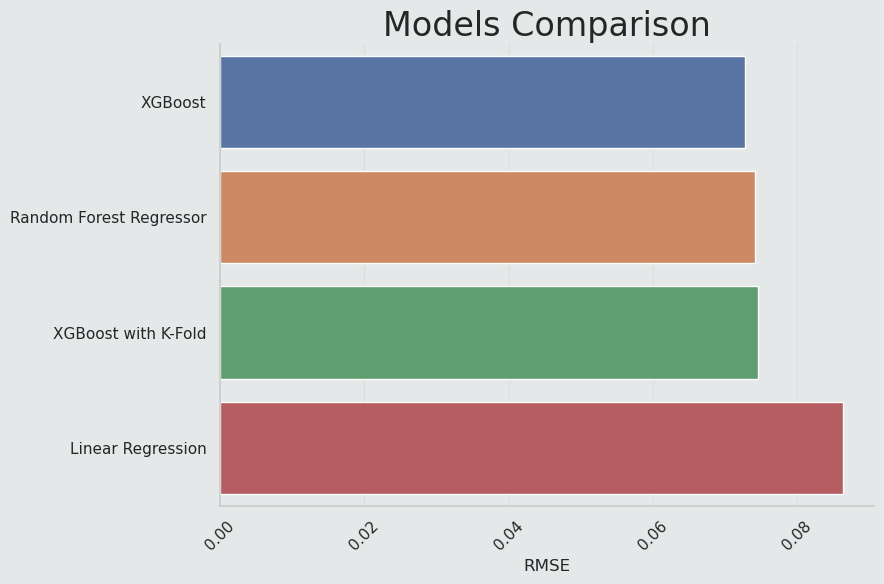

In [66]:
# Sort dataframe by the metric
performance.sort_values('RMSE', inplace=True)

# Create figure
figure = plt.figure(tight_layout=True, figsize=(9, 6))

# Plot models' metrics
ax = sns.barplot(data=performance, 
                 x='RMSE', 
                 y=performance.index.tolist())

# Set title
ax.set_title('Models Comparison', 
             fontsize=24)

# Set tick rotation
plt.xticks(rotation=45)

# Plot with tight layout
plt.tight_layout()

- XGBoost performs better in terms of RMSE

## Feature Importance

findfont: Font family ['Andale Mono'] not found. Falling back to DejaVu Sans.


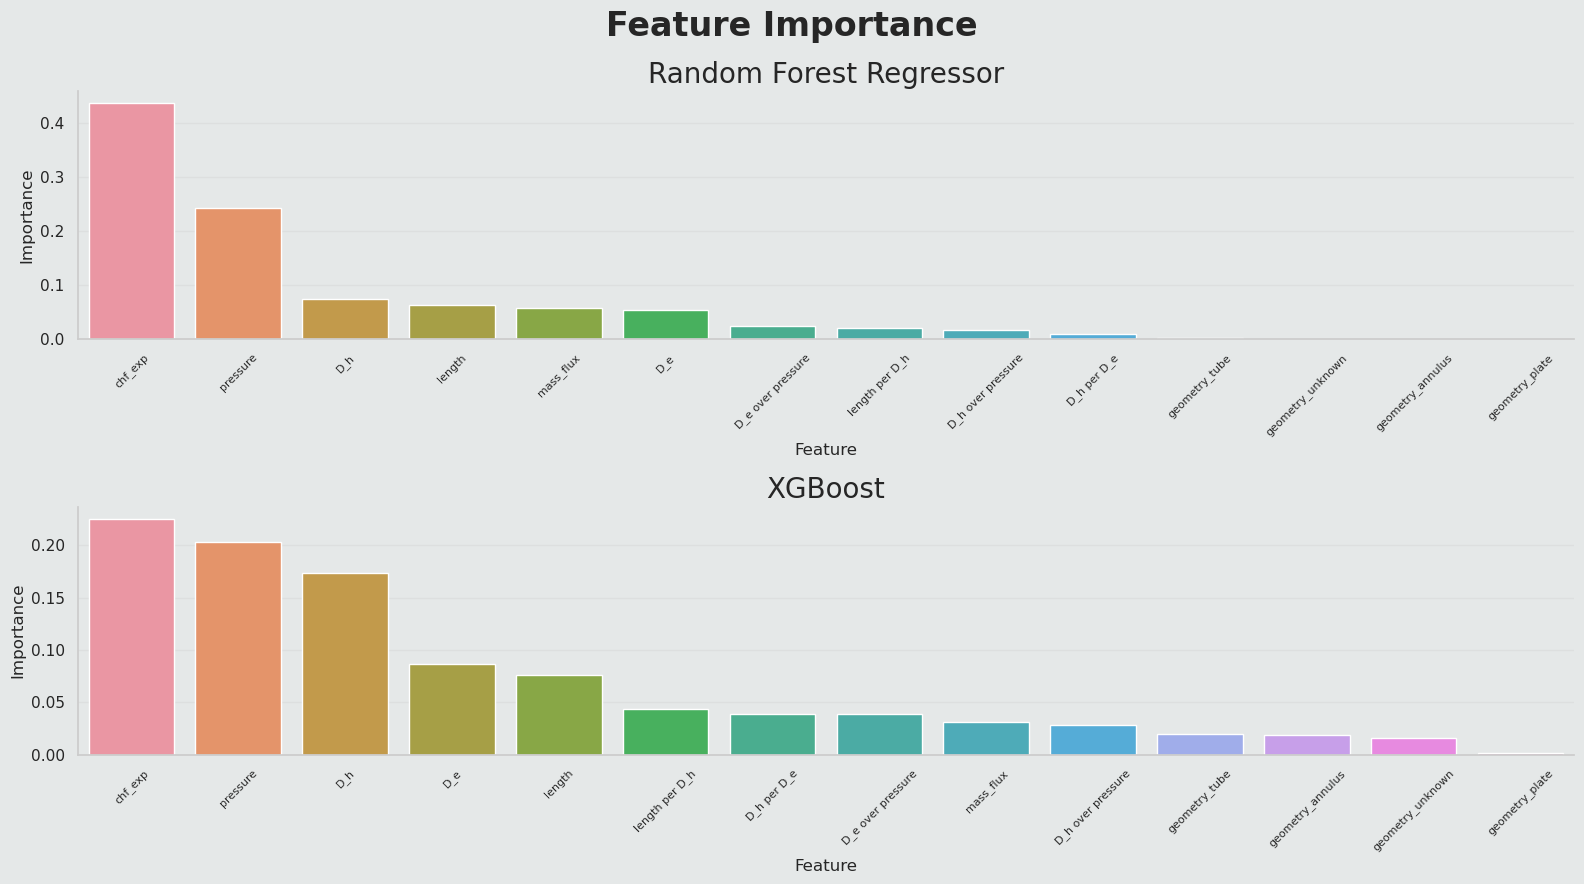

In [67]:
# Define figure and axes
figure, ax = plt.subplots(2, 1, figsize=(16, 9))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Retrieve feature names
    feature_names = models[model_name].named_steps['data_preprocessing'].get_feature_names_out()
    
    # Refactor feature names to remove the ColumnTransformer prefix
    feature_names = [feature_name.split('__')[-1] for feature_name in feature_names]
    
    # Retrieve pipeline model's step name
    pipe_model_step_name = list(models[model_name].named_steps.keys())[-1]
    
    # Retrieve feature importances values
    try:
        # Tree-based models
        feautre_importance_values = models[model_name].named_steps[pipe_model_step_name].feature_importances_
    except:
        # Regression-based models
        feautre_importance_values = models[model_name].named_steps[pipe_model_step_name].coef_.reshape(-1,)
        
    
    
    # Compute the feature importance
    feature_importance = sorted(list(zip(feature_names,
                                         feautre_importance_values)),
                                key=lambda x: x[1], reverse=True)

    # Transform it into a DataFrame
    feature_importance_df = pd.DataFrame(feature_importance,
                                         columns= ['Feature', 'Importance'])    
    
    # Plot the feature importance
    sns.barplot(data=feature_importance_df,
               x='Feature',
               y='Importance', 
               ax=ax[index])

    # Set title
    ax[index].set_title(model_name, 
                 fontsize=20)

    # Refine x labels
    ax[index].set_xticklabels(feature_importance_df['Feature'],
                              fontsize=8,
                              rotation=45)

# Define figure title
figure.suptitle('Feature Importance',
                fontweight='bold',
                fontsize=24)

# Plot with tight layout
plt.tight_layout()

- The original dataset label has a huge impact on the feature imputation. It makes sense, since it is probably inferenced from the feature

## Learning Curves

In [68]:
# Define Learning Curves Display parameters
learning_curves_display_paramters = {
    'X': X,
    'y': y,
    'cv': ShuffleSplit(n_splits=3, test_size=0.3, random_state=108),
    'train_sizes': np.linspace(0.1, 1.0, 8),
    'scoring': 'neg_root_mean_squared_error',
    'negate_score': True,
    'score_name': 'RMSE',
    'score_type': 'both',
    'verbose': 0,
    'line_kw': {'marker': 'o'},
    'std_display_style': 'fill_between',
}

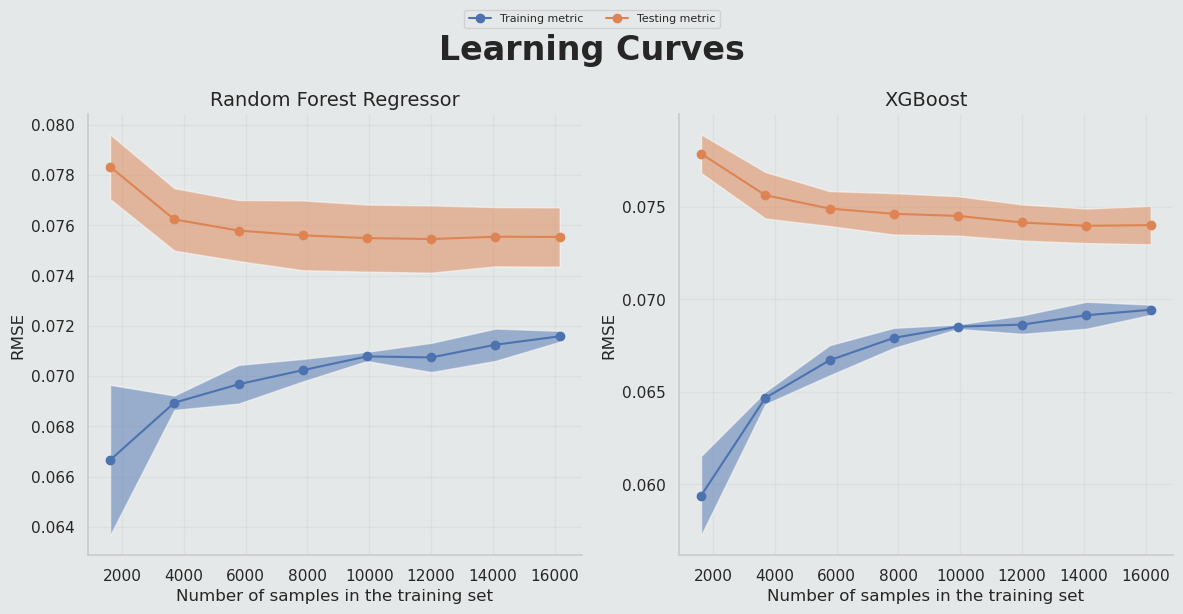

In [69]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):

    # Plot the Learning Curve
    LearningCurveDisplay.from_estimator(models[model_name], 
                                        **learning_curves_display_paramters,
                                        ax=ax[index])
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
    # Set the title
    ax[index].set_title(model_name, fontsize=14)
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='upper center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=8,
              ncol=2)

# Define figure title
figure.suptitle('Learning Curves',
                fontweight='bold',
                fontsize=24)
    
# Plot with tight layout
plt.tight_layout()

- The XGBoost has a slightly more covnergent curves

## Residuals

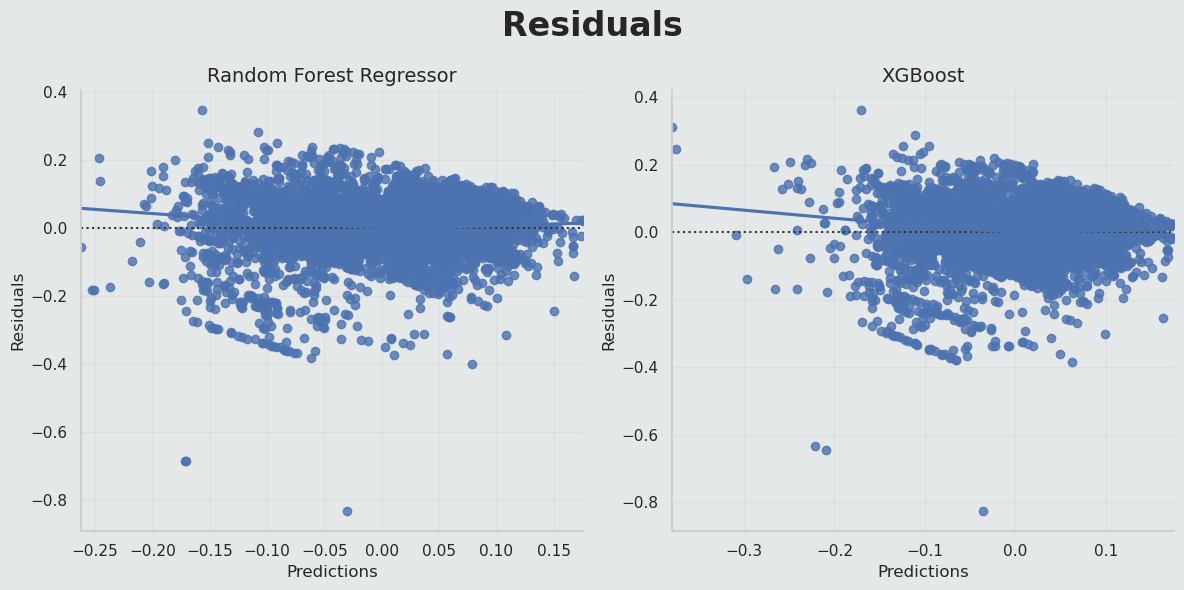

In [70]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Compute the predictions for the test set
    predictions = models[model_name].predict(X_test)
    
    # Reshape predictions
    predictions = predictions.reshape(-1,)
    
    # Compute the residuals
    residuals = y_test - predictions
    
    # Create the Pandas DataFrame
    residuals_df = pd.DataFrame({'Residuals': residuals, 
                                 'Predictions': predictions})
    
    # Plot the residuals
    sns.residplot(x='Predictions', 
                  y='Residuals',
                  data=residuals_df, 
                  ax=ax[index],
                  lowess=True)

    # Set the title
    ax[index].set_title(model_name, fontsize=14)

# Define figure title
figure.suptitle('Residuals',
                fontweight='bold',
                fontsize=24)

# Plot with tight layout
plt.tight_layout()

- Both models do not perform well while imputing the low values

## Q-Q Plots

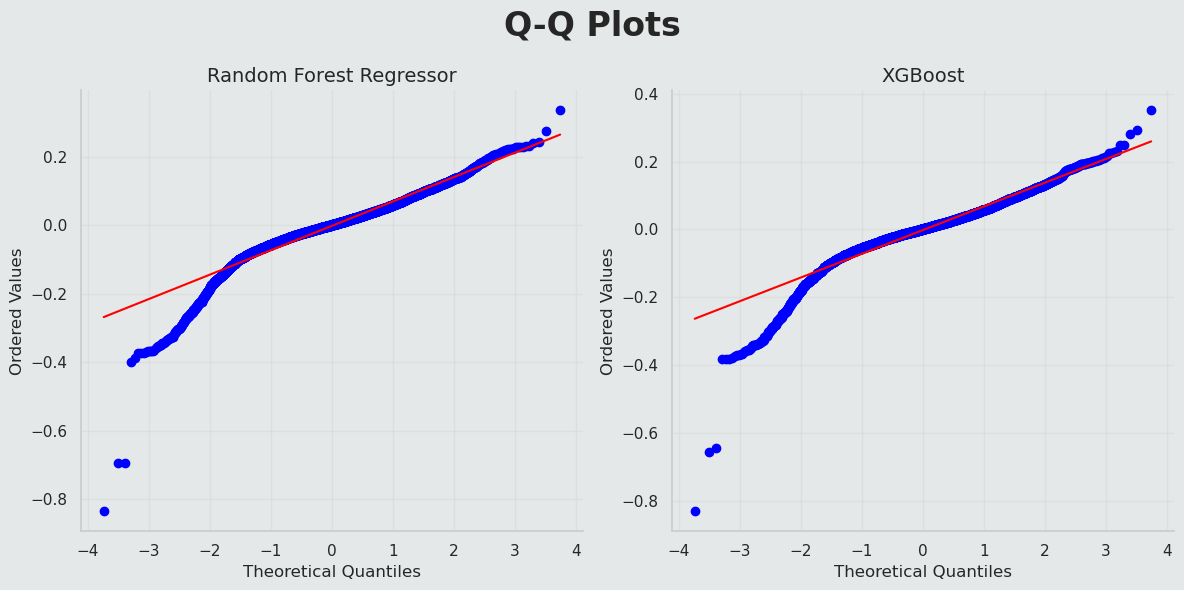

In [71]:
# Define figure and axes
figure, ax = plt.subplots(1, 2, figsize=(12, 6))
ax = ax.flatten()

# Fetch all the trained models
for index, model_name in enumerate(models.keys()):
    
    # Compute the predictions for the test set
    predictions = models[model_name].predict(X_test)
    
    # Reshape predictions
    predictions = predictions.reshape(-1,)
    
    # Compute the residuals
    residuals = y_test - predictions
    
    # Generate a QQ plot
    stats.probplot(residuals, 
                   plot=ax[index])
    
    ax[index].set_xlabel('Theoretical Quantiles')

    # Set the title
    ax[index].set_title(model_name, fontsize=14)
    
    
figure.suptitle('Q-Q Plots',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- Another confirmation of what has been diagnosed from the Residuals plot

## Model Diagnostic

- XGBoost performs better in terms of RMSE
- XGBoost learns slightly better from the data
- The models do not impute well the low values

# Submission

In [86]:
# Generate predictions with test set
submission_predictions = pipe_xgb_kfold.predict(test_data_cleaned)

In [87]:
# Create submission DataFrame
submission = pd.DataFrame({'id': test_data_cleaned.index, 'x_e_out [-]': submission_predictions})

In [88]:
# Write CSV File
submission.to_csv('./submission.csv', index=False)